# Imports

In [5]:
import pickle

import torch
from torch.utils.data import Dataset, DataLoader

from collections import Counter

import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F

from torchinfo import summary
from torchviz import make_dot
from torchview import draw_graph

from transformers import BertModel, BertTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
# load the processed data 
with open('outputs_processing/processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

# unpack everything you saved
X_train_tfidf = data['X_train_tfidf']
X_test_tfidf  = data['X_test_tfidf']
y_train_enc   = data['y_train_enc']
y_test_enc    = data['y_test_enc']

X_train = data['X_train']
X_test  = data['X_test']
y_train = data['y_train']
y_test  = data['y_test']

X = data['X']
y = data['y']

print("Data loaded successfully from outputs_processing/processed_data.pkl")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Example text: {X_train[0][:120]}...")

Data loaded successfully from outputs_processing/processed_data.pkl
Train samples: 9912, Test samples: 4248
Example text: complexity course concentrated last week...


In [3]:
len(X_train)

9912

In [4]:
len(X_test)

4248

# Setup Device

In [4]:
device = torch.device("cpu")
print(device)

cpu


# Load Tokenizer and BERT

In [6]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
bert = BertModel.from_pretrained(MODEL_NAME)


In [8]:
for name, param in bert.named_parameters():
    print(name)


embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [9]:
base_model = BertModel.from_pretrained("bert-base-uncased")

for name, param in base_model.named_parameters():
    # Freeze all layers by default
    param.requires_grad = False

    # Unfreeze the last 2 encoder layers + pooler
    if "encoder.layer.10" in name or "encoder.layer.11" in name or "pooler" in name:
        param.requires_grad = True

In [10]:
trainable = [n for n, p in base_model.named_parameters() if p.requires_grad]
print("Trainable layers:")
for n in trainable:
    print(" ", n)
print(f"\nTotal trainable layers: {len(trainable)}")


Trainable layers:
  encoder.layer.10.attention.self.query.weight
  encoder.layer.10.attention.self.query.bias
  encoder.layer.10.attention.self.key.weight
  encoder.layer.10.attention.self.key.bias
  encoder.layer.10.attention.self.value.weight
  encoder.layer.10.attention.self.value.bias
  encoder.layer.10.attention.output.dense.weight
  encoder.layer.10.attention.output.dense.bias
  encoder.layer.10.attention.output.LayerNorm.weight
  encoder.layer.10.attention.output.LayerNorm.bias
  encoder.layer.10.intermediate.dense.weight
  encoder.layer.10.intermediate.dense.bias
  encoder.layer.10.output.dense.weight
  encoder.layer.10.output.dense.bias
  encoder.layer.10.output.LayerNorm.weight
  encoder.layer.10.output.LayerNorm.bias
  encoder.layer.11.attention.self.query.weight
  encoder.layer.11.attention.self.query.bias
  encoder.layer.11.attention.self.key.weight
  encoder.layer.11.attention.self.key.bias
  encoder.layer.11.attention.self.value.weight
  encoder.layer.11.attention.self.v

# Create Dataset Class

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)  
        }

# Create LSTM CLASS

In [ ]:
class BertBiLSTMForClassification(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_classes=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(768, 320, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(320*2, 80),
            nn.ReLU(),
            nn.Linear(80, num_classes)
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq_out = outputs.last_hidden_state                # [B, L, 768]
        lstm_out, _ = self.lstm(seq_out)                   # [B, L, 640]
        pooled = lstm_out[:, -1, :]                        # last time step
        logits = self.fc(pooled)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}


# Training Loop

In [ ]:
BATCH_SIZE = 2

test_dataset = TextDataset(
    texts=X_test.tolist() if hasattr(X_test, "tolist") else list(X_test),
    labels=y_test_enc.tolist() if hasattr(y_test_enc, "tolist") else list(y_test_enc),
    tokenizer=tokenizer,
    max_len=128
)


test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)


train_dataset = TextDataset(
    texts=X_train.tolist() if hasattr(X_train, "tolist") else list(X_train),
    labels=y_train_enc.tolist() if hasattr(y_train, "tolist") else list(y_train),
    tokenizer=tokenizer,
    max_len=128
)


train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

model = BertBiLSTMForClassification(num_classes=3)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")

    probs = torch.softmax(torch.tensor(pred.predictions), dim=1).numpy()
    y_true_bin = np.eye(3)[labels]
    auc_macro = roc_auc_score(y_true_bin, probs, average="macro", multi_class="ovr")

    return {"accuracy": acc, "f1": f1, "auc_macro": auc_macro}

training_args = TrainingArguments(
    output_dir="./results_bilstm",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

df = pd.DataFrame(trainer.state.log_history)
display(df.tail())



optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_accs, val_accs = [], []
train_f1s,  val_f1s  = [], []
train_aucs, val_aucs = [], []
train_losses, val_losses = [], []

for epoch in range(2):
    model.train()
    total_loss = 0
    y_true_train, y_pred_train, y_prob_train = [], [], []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1} [Train]"):
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())
        y_prob_train.extend(probs.cpu().numpy())

    # ===== TRAIN METRICS =====
    train_loss = total_loss / len(train_dataloader)
    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_f1 = f1_score(y_true_train, y_pred_train, average='macro')
    y_true_bin = np.eye(3)[y_true_train]  # one-hot for AUC
    train_auc = roc_auc_score(y_true_bin, np.array(y_prob_train), average='macro', multi_class='ovr')

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    train_aucs.append(train_auc)

    # ===== VALIDATION / TEST METRICS =====
    model.eval()
    total_loss = 0
    y_true_val, y_pred_val, y_prob_val = [], [], []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Epoch {epoch+1} [Eval]"):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(preds.cpu().numpy())
            y_prob_val.extend(probs.cpu().numpy())

    val_loss = total_loss / len(test_dataloader)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    val_f1 = f1_score(y_true_val, y_pred_val, average='macro')
    y_true_bin = np.eye(3)[y_true_val]
    val_auc = roc_auc_score(y_true_bin, np.array(y_prob_val), average='macro', multi_class='ovr')

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    val_aucs.append(val_auc)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f" Train  - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f}")
    print(f" Test   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")



100%|██████████| 4956/4956 [37:10<00:00,  2.22it/s]


Epoch 1, Loss: 0.8757


100%|██████████| 4956/4956 [38:02<00:00,  2.17it/s]

Epoch 2, Loss: 0.8160


# Evaluation

In [26]:
print(len(train_dataloader))
print(len(test_dataloader))

4956
2124


In [27]:
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(ids, mask)  # dict input if using base_model(**inputs)
        probs = torch.softmax(outputs, dim=1)  # convert logits → probabilities

        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())  # needed for ROC-AUC


100%|██████████| 2124/2124 [07:54<00:00,  4.47it/s]


In [30]:
print(classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0     0.6370    0.6109    0.6236      1416
           1     0.5163    0.5155    0.5159      1416
           2     0.7304    0.7613    0.7455      1416

    accuracy                         0.6292      4248
   macro avg     0.6279    0.6292    0.6284      4248
weighted avg     0.6279    0.6292    0.6284      4248

Confusion matrix:
 [[ 865  437  114]
 [ 402  730  284]
 [  91  247 1078]]


In [31]:
from sklearn.preprocessing import label_binarize

num_classes = 3
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
y_prob = np.array(y_prob)

auc_macro = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
print(f"Macro ROC-AUC: {auc_macro:.4f}")


Macro ROC-AUC: 0.8084


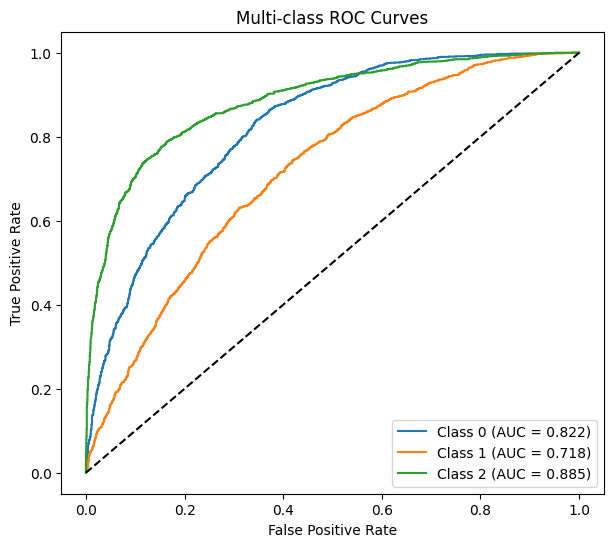

In [34]:
plt.figure(figsize=(7,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves")
plt.legend()
plt.show()
